In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
from sklearn.cluster import AffinityPropagation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid, KFold
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

In [3]:
raw = pd.read_csv('/content/classification_test.csv')

In [4]:
raw.head()

,x1,x2,target
0,1.114204,-0.434321,1
1,-1.238490,0.521390,0
2,-0.091781,-0.169471,1
3,0.298820,0.076368,0
4,-0.265779,0.479812,1


In [5]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      330 non-null    float64
 1   x2      330 non-null    float64
 2   target  330 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 7.9 KB


In [6]:
raw.describe()

,x1,x2,target
count,330.000000,330.000000,330.000000
mean,0.472470,0.266104,0.487879
std,0.986760,0.583819,0.500612
min,-1.693028,-1.031435,0.000000
25%,-0.264152,-0.190844,0.000000
50%,0.503077,0.240346,0.000000
75%,1.218472,0.680558,1.000000
max,2.528373,1.783693,1.000000


In [7]:
raw["target"].value_counts()

,count
target,
0,169
1,161


<Axes: xlabel='x1', ylabel='x2'>

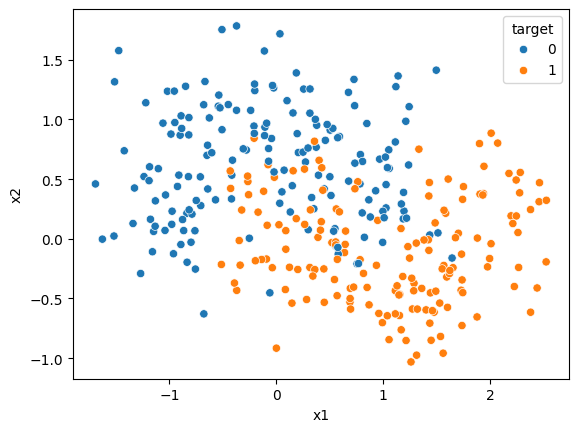

In [8]:
sns.scatterplot(raw, x="x1", y="x2", hue="target")

<Axes: >

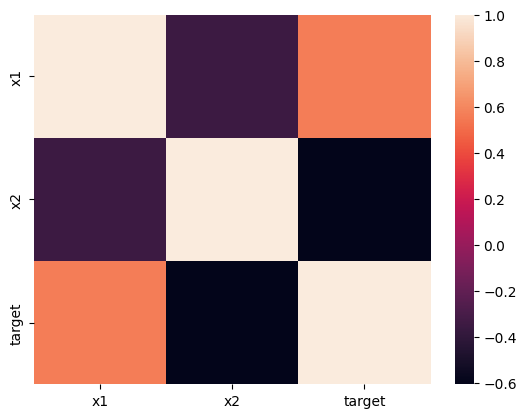

In [9]:
sns.heatmap(raw.corr())

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    raw.drop(columns="target"), raw["target"], test_size=0.25
)

In [11]:
len(X_train)

247

In [12]:
len(X_test)

83

In [16]:
def get_best_classifier(df, target_col='target'):
    X = df.drop(columns=[target_col]).values
    y = df[target_col].values

    best_f1 = 0
    best_model = None
    best_params = None
    best_metrics = {}

    # Hiperparametros a varrer pra cada modelo
    model_params = {
        'GaussianProcess': {
            'max_iter_predict': [30, 60, 120]
        },
        'RandomForest': {
            'n_estimators': [75, 96, 150],
            'max_depth': [None, 4, 8, 12, 16],
            'min_samples_split': [2, 3, 4]
        },
        'XGBoost': {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 9, 18],
            'learning_rate': [0.01, 0.1, 0.25]
        },
        'SVM': {
            'C': [0.1, 1, 10],
            'gamma': ['scale', 'auto', 0.1, 0.01]
        },
        'MLP': {
            'hidden_layer_sizes': [(4,2), (8,4), (16,8)],
            'learning_rate_init': [0.00025, 0.001, 0.015],
            'max_iter': [1500]
        }
    }

    # Validacao cruzada, alternando os splits de train/test
    kf = KFold(n_splits=5, shuffle=True)

    # Iterar sobre cada combinacao de modelo e hiperparametros
    for model_name, params in model_params.items():
        print(f"Training {model_name}...")
        for param_combination in ParameterGrid(params):
            fold_f1_scores = []
            fold_precisions = []
            fold_recalls = []

            for train_index, val_index in kf.split(X):
                X_train, X_val = X[train_index], X[val_index]
                y_train, y_val = y[train_index], y[val_index]

                if model_name == 'GaussianProcess':
                    model = GaussianProcessClassifier(**{k: v for k, v in param_combination.items() if v is not None})
                elif model_name == 'RandomForest':
                    model = RandomForestClassifier(**param_combination)
                elif model_name == 'XGBoost':
                    model = XGBClassifier(**param_combination)
                elif model_name == 'SVM':
                    model = SVC(**param_combination)
                elif model_name == 'MLP':
                    model = MLPClassifier(**param_combination)

                model.fit(X_train, y_train)
                y_pred = model.predict(X_val)

                fold_f1_scores.append(f1_score(y_val, y_pred, average='weighted'))
                fold_precisions.append(precision_score(y_val, y_pred, average='weighted'))
                fold_recalls.append(recall_score(y_val, y_pred, average='weighted'))


            avg_f1 = np.mean(fold_f1_scores)
            avg_precision = np.mean(fold_precisions)
            avg_recall = np.mean(fold_recalls)

            print(f"{model_name}, params {param_combination}: F1={avg_f1:.3f}")

            if avg_f1 > best_f1:
                best_f1 = avg_f1
                best_model = model
                best_params = param_combination
                best_metrics = {
                    'model': model_name,
                    'f1_score': avg_f1,
                    'precision': avg_precision,
                    'recall': avg_recall
                }

    return best_model, best_params, best_metrics

In [17]:
clustering_model_results = get_best_classifier(raw)

Training GaussianProcess...
GaussianProcess with params {'max_iter_predict': 30}: F1=0.855
GaussianProcess with params {'max_iter_predict': 60}: F1=0.854
GaussianProcess with params {'max_iter_predict': 120}: F1=0.843
Training RandomForest...
RandomForest with params {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 75}: F1=0.842
RandomForest with params {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 96}: F1=0.854
RandomForest with params {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 150}: F1=0.861
RandomForest with params {'max_depth': None, 'min_samples_split': 3, 'n_estimators': 75}: F1=0.854
RandomForest with params {'max_depth': None, 'min_samples_split': 3, 'n_estimators': 96}: F1=0.855
RandomForest with params {'max_depth': None, 'min_samples_split': 3, 'n_estimators': 150}: F1=0.857
RandomForest with params {'max_depth': None, 'min_samples_split': 4, 'n_estimators': 75}: F1=0.864
RandomForest with params {'max_depth': None, 'min_samples_spli

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


SVM with params {'C': 0.1, 'gamma': 0.01}: F1=0.392
SVM with params {'C': 1, 'gamma': 'scale'}: F1=0.860
SVM with params {'C': 1, 'gamma': 'auto'}: F1=0.867
SVM with params {'C': 1, 'gamma': 0.1}: F1=0.831
SVM with params {'C': 1, 'gamma': 0.01}: F1=0.800
SVM with params {'C': 10, 'gamma': 'scale'}: F1=0.882
SVM with params {'C': 10, 'gamma': 'auto'}: F1=0.867
SVM with params {'C': 10, 'gamma': 0.1}: F1=0.833
SVM with params {'C': 10, 'gamma': 0.01}: F1=0.821
Training MLP...


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to co

MLP with params {'hidden_layer_sizes': (4, 2), 'learning_rate_init': 0.00025, 'max_iter': 1500}: F1=0.637


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP with params {'hidden_layer_sizes': (4, 2), 'learning_rate_init': 0.001, 'max_iter': 1500}: F1=0.845


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


MLP with params {'hidden_layer_sizes': (4, 2), 'learning_rate_init': 0.015, 'max_iter': 1500}: F1=0.727


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


MLP with params {'hidden_layer_sizes': (8, 4), 'learning_rate_init': 0.00025, 'max_iter': 1500}: F1=0.716
MLP with params {'hidden_layer_sizes': (8, 4), 'learning_rate_init': 0.001, 'max_iter': 1500}: F1=0.832
MLP with params {'hidden_layer_sizes': (8, 4), 'learning_rate_init': 0.015, 'max_iter': 1500}: F1=0.873
MLP with params {'hidden_layer_sizes': (16, 8), 'learning_rate_init': 0.00025, 'max_iter': 1500}: F1=0.846
MLP with params {'hidden_layer_sizes': (16, 8), 'learning_rate_init': 0.001, 'max_iter': 1500}: F1=0.879
MLP with params {'hidden_layer_sizes': (16, 8), 'learning_rate_init': 0.015, 'max_iter': 1500}: F1=0.870


In [18]:
print(clustering_model_results)

(SVC(C=10), {'C': 10, 'gamma': 'scale'}, {'model': 'SVM', 'f1_score': 0.8819881348962832, 'precision': 0.8871591377492495, 'recall': 0.8818181818181818})


In [19]:
classifier = SVC(C=10, gamma='scale')

In [20]:
classifier.fit(X_train, y_train)

SVC(C=10)

In [21]:
predictions = classifier.predict(X_test)

In [22]:
conf_matrix = confusion_matrix(y_test, predictions)

# Matriz de confusão
print("Confusion Matrix:")
print(conf_matrix)


f1 = f1_score(y_test, predictions, average='weighted')
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')
accuracy = accuracy_score(y_test, predictions)

# Metricas
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Accuracy: {accuracy:.2f}")

Confusion Matrix:
[[38  3]
 [ 6 36]]
F1 Score: 0.89
Precision: 0.89
Recall: 0.89
Accuracy: 0.89


In [23]:
raw["prediction"] = classifier.predict(raw.drop(columns="target"))

<Axes: xlabel='x1', ylabel='x2'>

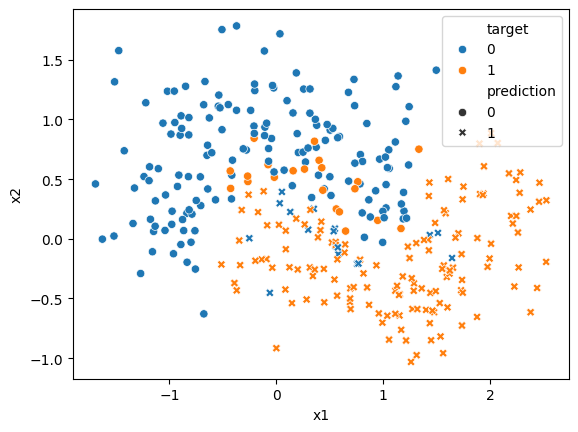

In [24]:
sns.scatterplot(raw, x="x1", y="x2", hue="target", style="prediction")

In [25]:
raw['predicted_right'] = (raw['target'] == raw['prediction']).astype(int)

<Axes: xlabel='x1', ylabel='x2'>

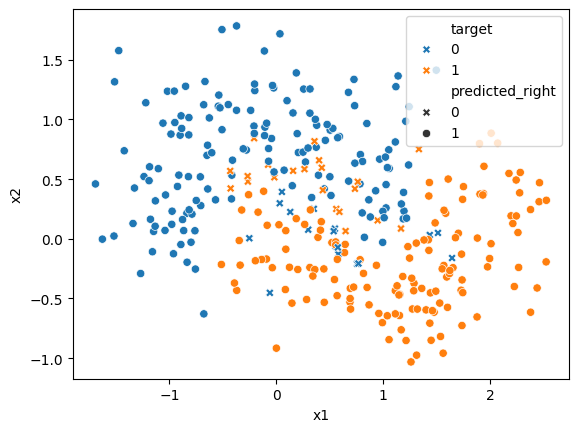

In [30]:
sns.scatterplot(data=raw, x="x1", y="x2", hue="target", style="predicted_right", markers={1: 'o', 0: 'X'})